In [3]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('./subwayall/mansale.csv', index_col = 0)

In [4]:
df = pd.read_csv('./subwayall/modeldata.csv', index_col = 0)

In [5]:
df.shape

(9482, 19)

Text(0.5, 1.0, 'Property Type')

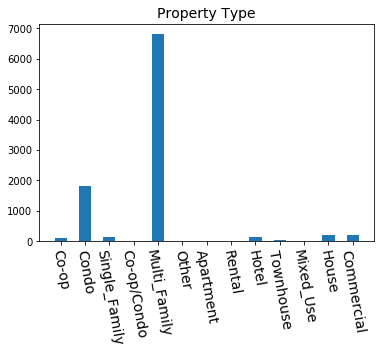

In [7]:
# draw property type distribution
label = []
num = []
for i, j in enumerate(df[list(df.columns)[5:-1]].sum()):
    label.append(list(df.columns)[5:-1][i])
    num.append(int(j))
N =13
ind = np.arange(N)
plt.bar(ind, num, width = 0.5)
plt.xticks(ind, ('Co-op', 'Condo', 'Single_Family', 'Co-op/Condo', 'Multi_Family', 'Other', 'Apartment', 'Rental', 'Hotel', 'Townhouse', 'Mixed_Use', 'House', 'Commercial'),
           rotation=-80, fontsize=14)
plt.title('Property Type', fontsize=14)

In [8]:
df = df[df['subway_distance'] < 10]
df = df[df['bedroom'] != 99]
info = df[['bathroom','bedroom', 'size', 'subway_distance']].describe()
info.iloc[1:,:]

,bathroom,bedroom,size,subway_distance
mean,2.502062,2.396881,15333.089585,0.024443
std,1.557975,1.567340,18038.171452,0.297651
min,0.000000,0.000000,210.000000,0.000000
25%,2.000000,2.000000,4352.500000,0.000561
50%,2.000000,2.000000,10295.000000,0.003100
75%,3.000000,3.000000,18750.000000,0.013189
max,39.000000,25.000000,248470.000000,9.663903


In [11]:
df.columns

Index(['bathroom', 'bedroom', 'restaurant_level', 'size', 'subway_distance',
       'Co-op', 'Condo', 'Single_Family', 'Co-op/Condo', 'Multi_Family',
       'Other', 'Apartment', 'Rental', 'Hotel', 'Townhouse', 'Mixed_Use',
       'House', 'Commercial', 'price'],
      dtype='object')

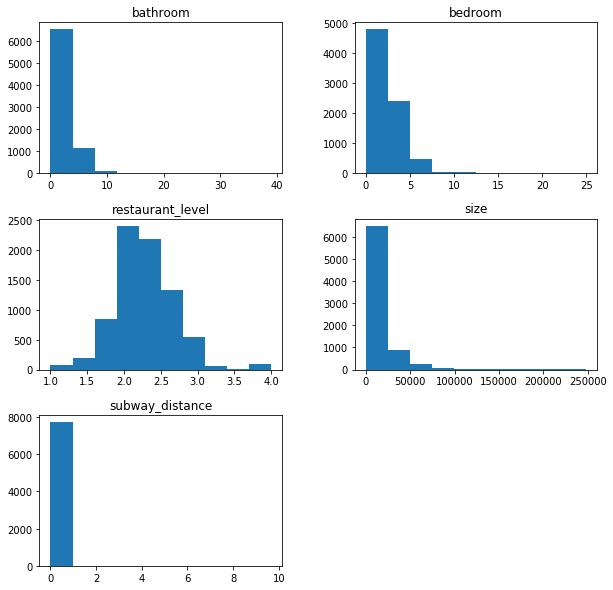

In [9]:
df[['bathroom', 'bedroom', 'restaurant_level', 'size', 'subway_distance']].hist(figsize = (10,10), grid = False)
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
x=df.iloc[:,0:18]
y=df.iloc[:,18].values.reshape([-1,1])
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))


xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size = 0.2)

In [11]:
# draw results
def chart(y_pred, y_test, start, end, title):
    absouted = abs(scaler_y.inverse_transform(y_test) - scaler_y.inverse_transform(y_pred))
    ab = []
    for i in absouted:
        ab.extend(i)
    ind = np.argsort(ab)[start:end]
    y_true_test = []
    for i in scaler_y.inverse_transform(y_test)[ind]:
        y_true_test.extend(i)

    y_true_pred = []
    for i in scaler_y.inverse_transform(y_pred)[ind]:
        y_true_pred.extend(-i)  
    index = np.arange(100)
    width = 0.35
    p1 = plt.bar(index,y_true_test, width)
    p2 = plt.bar(index, y_true_pred, width)
    plt.title(title)
    plt.show()   

# 1. Linear Regression

In [14]:
from sklearn import linear_model
model = linear_model.LinearRegression()
reg = model.fit(X_train,y_train)

In [22]:
y_pred = model.predict(X_test)
y_pred.shape

(1552, 1)

In [21]:
print('Variance score: {}'.format(reg.score(X_test, y_test))) 

Variance score: 0.6337165801006263


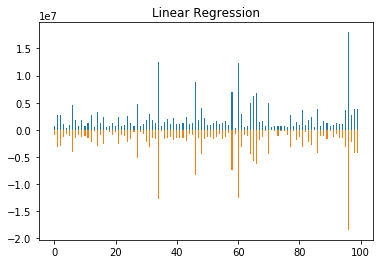

In [23]:
chart(y_pred,y_test,200,300, 'Linear Regression')

# 2. DNN

In [26]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


Using TensorFlow backend.


In [27]:
NN_model = Sequential()

# The Input Layer :
#128是输出的feature维度，input输入feature维度
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 167,297
Trainable params: 167,297
Non-trainable params: 0
_________________________________________________________________


In [28]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [29]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 4964 samples, validate on 1242 samples
Epoch 1/500
4964/4964 [==============================] - 1s 120us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00001: val_loss improved from inf to 0.00198, saving model to Weights-001--0.00198.hdf5
Epoch 2/500
4964/4964 [==============================] - 0s 88us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00002: val_loss improved from 0.00198 to 0.00158, saving model to Weights-002--0.00158.hdf5
Epoch 3/500
4964/4964 [==============================] - 0s 89us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00003: val_loss did not improve from 0.00158
Epoch 4/500
4964/4964 [==============================] - 0s 86us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00004: val_loss improved from 0.00


Epoch 00036: val_loss did not improve from 0.00111
Epoch 37/500
4964/4964 [==============================] - 0s 98us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00037: val_loss did not improve from 0.00111
Epoch 38/500
4964/4964 [==============================] - 1s 101us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00038: val_loss did not improve from 0.00111
Epoch 39/500
4964/4964 [==============================] - 0s 87us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00039: val_loss did not improve from 0.00111
Epoch 40/500
4964/4964 [==============================] - 0s 85us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00040: val_loss did not improve from 0.00111
Epoch 41/500
4964/4964 [==============================] - 0s 79us/step 

4964/4964 [==============================] - 0s 71us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00074: val_loss did not improve from 0.00111
Epoch 75/500
4964/4964 [==============================] - 0s 76us/step - loss: 9.9060e-04 - mean_squared_error: 9.9060e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00075: val_loss did not improve from 0.00111
Epoch 76/500
4964/4964 [==============================] - 0s 71us/step - loss: 9.7598e-04 - mean_squared_error: 9.7598e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

Epoch 00076: val_loss did not improve from 0.00111
Epoch 77/500
4964/4964 [==============================] - 0s 75us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

Epoch 00077: val_loss did not improve from 0.00111
Epoch 78/500
4964/4964 [==============================] - 0s 71us/step - loss: 9.6773e-04 - mean_squared_error: 9.6773e-0

4964/4964 [==============================] - 0s 69us/step - loss: 9.3913e-04 - mean_squared_error: 9.3913e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00110: val_loss did not improve from 0.00107
Epoch 111/500
4964/4964 [==============================] - 0s 68us/step - loss: 9.1831e-04 - mean_squared_error: 9.1831e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00111: val_loss did not improve from 0.00107
Epoch 112/500
4964/4964 [==============================] - 0s 69us/step - loss: 9.3086e-04 - mean_squared_error: 9.3087e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

Epoch 00112: val_loss did not improve from 0.00107
Epoch 113/500
4964/4964 [==============================] - 0s 69us/step - loss: 9.0502e-04 - mean_squared_error: 9.0502e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00113: val_loss did not improve from 0.00107
Epoch 114/500
4964/4964 [==============================] - 0s 67us/step - loss: 8.8546e-04 - mean_squa

4964/4964 [==============================] - 0s 71us/step - loss: 8.8424e-04 - mean_squared_error: 8.8424e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00146: val_loss did not improve from 0.00107
Epoch 147/500
4964/4964 [==============================] - 0s 71us/step - loss: 8.0043e-04 - mean_squared_error: 8.0043e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00147: val_loss did not improve from 0.00107
Epoch 148/500
4964/4964 [==============================] - 0s 71us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011

Epoch 00148: val_loss did not improve from 0.00107
Epoch 149/500
4964/4964 [==============================] - 0s 71us/step - loss: 7.9639e-04 - mean_squared_error: 7.9639e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00149: val_loss did not improve from 0.00107
Epoch 150/500
4964/4964 [==============================] - 0s 72us/step - loss: 7.7731e-04 - mean_squared_erro

4964/4964 [==============================] - 0s 70us/step - loss: 8.0364e-04 - mean_squared_error: 8.0364e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00182: val_loss did not improve from 0.00107
Epoch 183/500
4964/4964 [==============================] - 0s 71us/step - loss: 7.4885e-04 - mean_squared_error: 7.4885e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00183: val_loss did not improve from 0.00107
Epoch 184/500
4964/4964 [==============================] - 0s 70us/step - loss: 7.6937e-04 - mean_squared_error: 7.6937e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00184: val_loss did not improve from 0.00107
Epoch 185/500
4964/4964 [==============================] - 0s 69us/step - loss: 7.1715e-04 - mean_squared_error: 7.1715e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00185: val_loss did not improve from 0.00107
Epoch 186/500
4964/4964 [==============================] - 0s 72us/step - loss: 8.7493e-04 - mean_squa

4964/4964 [==============================] - 0s 69us/step - loss: 6.6734e-04 - mean_squared_error: 6.6734e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00218: val_loss did not improve from 0.00107
Epoch 219/500
4964/4964 [==============================] - 0s 70us/step - loss: 7.5343e-04 - mean_squared_error: 7.5343e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00219: val_loss did not improve from 0.00107
Epoch 220/500
4964/4964 [==============================] - 0s 70us/step - loss: 6.8737e-04 - mean_squared_error: 6.8737e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00220: val_loss did not improve from 0.00107
Epoch 221/500
4964/4964 [==============================] - 0s 70us/step - loss: 6.6800e-04 - mean_squared_error: 6.6800e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00221: val_loss did not improve from 0.00107
Epoch 222/500
4964/4964 [==============================] - 0s 70us/step - loss: 7.3648e-04 - mean_squa

4964/4964 [==============================] - 0s 76us/step - loss: 6.6001e-04 - mean_squared_error: 6.6001e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00254: val_loss did not improve from 0.00107
Epoch 255/500
4964/4964 [==============================] - 0s 71us/step - loss: 6.7732e-04 - mean_squared_error: 6.7732e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00255: val_loss did not improve from 0.00107
Epoch 256/500
4964/4964 [==============================] - 0s 71us/step - loss: 6.6083e-04 - mean_squared_error: 6.6083e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00256: val_loss did not improve from 0.00107
Epoch 257/500
4964/4964 [==============================] - 0s 74us/step - loss: 5.9632e-04 - mean_squared_error: 5.9632e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00257: val_loss did not improve from 0.00107
Epoch 258/500
4964/4964 [==============================] - 0s 77us/step - loss: 7.1546e-04 - mean_squa

4964/4964 [==============================] - 0s 71us/step - loss: 6.0594e-04 - mean_squared_error: 6.0594e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00290: val_loss did not improve from 0.00107
Epoch 291/500
4964/4964 [==============================] - 0s 69us/step - loss: 6.4352e-04 - mean_squared_error: 6.4352e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00291: val_loss did not improve from 0.00107
Epoch 292/500
4964/4964 [==============================] - 0s 69us/step - loss: 6.5635e-04 - mean_squared_error: 6.5635e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00292: val_loss did not improve from 0.00107
Epoch 293/500
4964/4964 [==============================] - 0s 69us/step - loss: 6.1638e-04 - mean_squared_error: 6.1638e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00293: val_loss did not improve from 0.00107
Epoch 294/500
4964/4964 [==============================] - 0s 70us/step - loss: 6.3147e-04 - mean_squa

4964/4964 [==============================] - 0s 70us/step - loss: 5.9154e-04 - mean_squared_error: 5.9154e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00326: val_loss did not improve from 0.00107
Epoch 327/500
4964/4964 [==============================] - 0s 70us/step - loss: 6.8949e-04 - mean_squared_error: 6.8949e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00327: val_loss did not improve from 0.00107
Epoch 328/500
4964/4964 [==============================] - 0s 68us/step - loss: 6.0565e-04 - mean_squared_error: 6.0565e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00328: val_loss did not improve from 0.00107
Epoch 329/500
4964/4964 [==============================] - 0s 69us/step - loss: 4.8408e-04 - mean_squared_error: 4.8408e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00329: val_loss did not improve from 0.00107
Epoch 330/500
4964/4964 [==============================] - 0s 70us/step - loss: 4.7929e-04 - mean_squa

4964/4964 [==============================] - 0s 71us/step - loss: 9.9080e-04 - mean_squared_error: 9.9080e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00362: val_loss did not improve from 0.00107
Epoch 363/500
4964/4964 [==============================] - 0s 73us/step - loss: 9.9719e-04 - mean_squared_error: 9.9719e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00363: val_loss did not improve from 0.00107
Epoch 364/500
4964/4964 [==============================] - 0s 72us/step - loss: 8.5965e-04 - mean_squared_error: 8.5965e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00364: val_loss did not improve from 0.00107
Epoch 365/500
4964/4964 [==============================] - 0s 71us/step - loss: 8.4468e-04 - mean_squared_error: 8.4468e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00365: val_loss did not improve from 0.00107
Epoch 366/500
4964/4964 [==============================] - 0s 70us/step - loss: 7.9126e-04 - mean_squa

4964/4964 [==============================] - 0s 70us/step - loss: 6.2321e-04 - mean_squared_error: 6.2321e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00398: val_loss did not improve from 0.00107
Epoch 399/500
4964/4964 [==============================] - 0s 70us/step - loss: 7.2533e-04 - mean_squared_error: 7.2533e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00399: val_loss did not improve from 0.00107
Epoch 400/500
4964/4964 [==============================] - 0s 82us/step - loss: 6.6928e-04 - mean_squared_error: 6.6928e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00400: val_loss did not improve from 0.00107
Epoch 401/500
4964/4964 [==============================] - 0s 86us/step - loss: 6.4690e-04 - mean_squared_error: 6.4690e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00401: val_loss did not improve from 0.00107
Epoch 402/500
4964/4964 [==============================] - 0s 70us/step - loss: 6.8511e-04 - mean_squa

4964/4964 [==============================] - 0s 69us/step - loss: 5.9584e-04 - mean_squared_error: 5.9584e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00434: val_loss did not improve from 0.00107
Epoch 435/500
4964/4964 [==============================] - 0s 72us/step - loss: 5.9607e-04 - mean_squared_error: 5.9607e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00435: val_loss did not improve from 0.00107
Epoch 436/500
4964/4964 [==============================] - 0s 70us/step - loss: 5.5136e-04 - mean_squared_error: 5.5136e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00436: val_loss did not improve from 0.00107
Epoch 437/500
4964/4964 [==============================] - 0s 74us/step - loss: 5.2713e-04 - mean_squared_error: 5.2713e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00437: val_loss did not improve from 0.00107
Epoch 438/500
4964/4964 [==============================] - 0s 84us/step - loss: 5.3994e-04 - mean_squa

4964/4964 [==============================] - 0s 82us/step - loss: 5.2052e-04 - mean_squared_error: 5.2052e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014

Epoch 00470: val_loss did not improve from 0.00107
Epoch 471/500
4964/4964 [==============================] - 0s 70us/step - loss: 4.1826e-04 - mean_squared_error: 4.1826e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

Epoch 00471: val_loss did not improve from 0.00107
Epoch 472/500
4964/4964 [==============================] - 0s 69us/step - loss: 4.0467e-04 - mean_squared_error: 4.0467e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00472: val_loss did not improve from 0.00107
Epoch 473/500
4964/4964 [==============================] - 0s 70us/step - loss: 4.8779e-04 - mean_squared_error: 4.8779e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00473: val_loss did not improve from 0.00107
Epoch 474/500
4964/4964 [==============================] - 0s 70us/step - loss: 5.7796e-04 - mean_squa

In [31]:
# Load wights file of the best model :

wights_file = 'Weights-082--0.00107.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [32]:
# test's mean_squared_error
MSE = NN_model.evaluate(X_train, y_train)[1]
print('DNN train MSE = ',MSE)
# test's mean_squared_error
MSE = NN_model.evaluate(X_test, y_test)[1]
print('DNN test MSE = ',MSE)

6206/6206 [==============================] - 0s 46us/step
DNN train MSE =  0.0009286314016208053
1552/1552 [==============================] - 0s 22us/step
DNN test MSE =  0.0014796025352552533


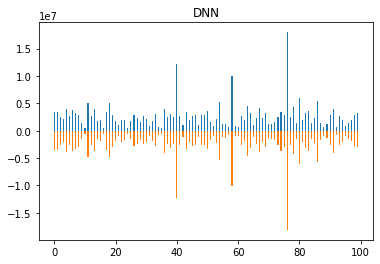

In [33]:
y_pred = NN_model.predict(X_test)
chart(y_pred,y_test, 100, 200, 'DNN')

# 3. Random Forest

### 3.1 Default params

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
RFmodel = RandomForestRegressor()
RFmodel.fit(X_train, y_train)

# Get the mean absolute error on the validation data
predicted_prices = RFmodel.predict(X_train)
MSE = mean_squared_error(y_train , predicted_prices)
print('Random forest train MSE = ', MSE)

Random forest train MSE =  0.00020604557362042926


In [36]:
predicted_test = RFmodel.predict(X_test)
MSE2 = mean_squared_error(y_test , predicted_test)
print('Random forest test MSE = ', MSE2)

Random forest test MSE =  0.001549687152395259


In [37]:
print('Train variance score: ', RFmodel.score(X_train, y_train))
print('Test variance score: ', RFmodel.score(X_test, y_test))

Train variance score:  0.9582591476608349
Test variance score:  0.7128235731340478


### 3.2 Find best n_estimators

In [38]:
param_test1 = {'n_estimators':range(10,101,10)}
rfsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=20,
                                  min_samples_leaf=10,max_depth=8 ,random_state=10), 
                       param_grid = param_test1, scoring='r2',cv=5)
rfsearch1.fit(X_train, y_train)
print('best param：{0}'.format(rfsearch1.best_params_))
print('best score:{0}'.format(rfsearch1.best_score_))

best param：{'n_estimators': 10}
best score:0.724925805906109


In [39]:
#Test new model scores
RFmodel1= RandomForestRegressor(n_estimators= 90, max_depth=8, min_samples_split=20,
                                 min_samples_leaf=10 ,random_state=10)
RFmodel1.fit(X_train, y_train)
print('Train variance score: ', RFmodel1.score(X_train, y_train))
print('Test variance score: ', RFmodel1.score(X_test, y_test))

Train variance score:  0.8043331896443456
Test variance score:  0.7142420086807323


### 3.2 Find best max_depth and min_samples_split

In [40]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(2,21,2)}
rfsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 90,
                                  min_samples_leaf=20,random_state=10), 
                       param_grid  = param_test2, scoring='r2',cv=5)
rfsearch2.fit(X_train, y_train)
print('best param：{0}'.format(rfsearch2.best_params_))
print('best score:{0}'.format(rfsearch2.best_score_))

best param：{'max_depth': 13, 'min_samples_split': 2}
best score:0.6923457828062298


In [41]:
#Test new model scores
RFmodel2= RandomForestRegressor(n_estimators= 90, max_depth=13, min_samples_split=2,
                                 min_samples_leaf=10,random_state=10)
RFmodel2.fit(X_train, y_train)
print('Train variance score: ', RFmodel2.score(X_train, y_train))
print('Test variance score: ', RFmodel2.score(X_test, y_test))

Train variance score:  0.8107848465905523
Test variance score:  0.717008585399832


### 3.3 Find best min_samples_leaf

In [42]:
param_test3 = {'min_samples_leaf':range(2,12,2)}
rfsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 90, max_depth=13, min_samples_split=2,
                                  random_state=10),
   param_grid = param_test3, scoring='r2', cv=5)
rfsearch3.fit(X_train, y_train)
print('best param：{0}'.format(rfsearch3.best_params_))
print('best score:{0}'.format(rfsearch3.best_score_))

best param：{'min_samples_leaf': 2}
best score:0.7573299467478164


In [43]:
RFmodel3= RandomForestRegressor(n_estimators= 90, max_depth=13, min_samples_split=2,
                                 min_samples_leaf=2,random_state=10)
RFmodel3.fit(X_train, y_train)
print('Train variance score: ', RFmodel3.score(X_train, y_train))
print('Test variance score: ', RFmodel3.score(X_test, y_test))

Train variance score:  0.9401708846564237
Test variance score:  0.7366713219341348


### 3.4 Final model

In [44]:
predicted_prices = RFmodel3.predict(X_train)
MSE = mean_squared_error(y_train , predicted_prices)
print('Random forest train MSE = ', MSE)

predicted_test = RFmodel3.predict(X_test)
MSE2 = mean_squared_error(y_test , predicted_test)
print('Random forest test MSE = ', MSE2)

Random forest train MSE =  0.0002953347547865752
Random forest test MSE =  0.001420997794663627


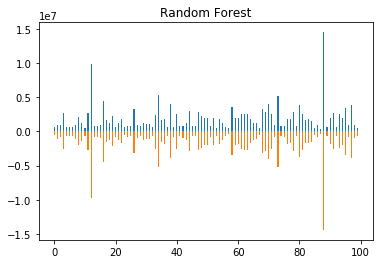

In [45]:
chart(predicted_test.reshape(-1,1),y_test, 100, 200, 'Random Forest')

# 4. XGBoost 

### 4.1 Default params

In [48]:
from xgboost import XGBRegressor
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_train)
MSE = mean_squared_error(y_train , XGBpredictions)
print('XGBoost train MSE = ',MSE)

[20:21:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost train MSE =  0.0007080602948602774


In [49]:
# Get the mean absolute error on the validation data :
XGBpredictions_y = XGBModel.predict(X_test)
MSE3 = mean_squared_error(y_test , XGBpredictions_y)
print('XGBoost test MSE = ',MSE3)

XGBoost test MSE =  0.0015110206086620705


In [50]:
print('Train variance score: ', XGBModel.score(X_train, y_train))
print('Test variance score: ', XGBModel.score(X_test, y_test))

Train variance score:  0.8565606642468624
Test variance score:  0.7199889676792566


### 4.2 Find best n_estimators

In [51]:
cv_params = {'n_estimators': [800, 900, 1000, 1100, 1200]}
other_params = {'learning_rate': 0.1, 'n_estimators': 900, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.0min finished


[20:22:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'n_estimators': 900}
best score:0.794923642579573


In [52]:
#Test new models
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
XGBModel1 = XGBRegressor(**other_params)
XGBModel1.fit(X_train, y_train)
print('Train variance score: ', XGBModel1.score(X_train, y_train))
print('Test variance score: ', XGBModel1.score(X_test, y_test))

[20:23:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train variance score:  0.9958729771480122
Test variance score:  0.7617922837833173


### 4.3 Find best max_depth

In [53]:
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)

print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  2.2min finished


[20:25:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'max_depth': 4}
best score:0.7962171571730889


In [54]:
#Test new models
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
XGBModel2 = XGBRegressor(**other_params)
XGBModel2.fit(X_train, y_train)
print('Train variance score: ', XGBModel2.score(X_train, y_train))
print('Test variance score: ', XGBModel2.score(X_test, y_test))

[20:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train variance score:  0.9717469769909145
Test variance score:  0.775883737312461


### 4.4 Find best gamma

In [55]:
#find best gamma
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)

print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.1min finished


[20:28:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'gamma': 0.1}
best score:0.7219596651984902


#### Best score is worse than before, gamma remains unchanged is better

### 4.5 Find best subsample and colsample_bytree

In [56]:
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)

print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  2.7min finished


[20:30:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'colsample_bytree': 0.8, 'subsample': 0.9}
best score:0.7882432870952385


In [57]:
#Test new models
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
XGBModel3 = XGBRegressor(**other_params)
XGBModel3.fit(X_train, y_train)
print('Train variance score: ', XGBModel3.score(X_train, y_train))
print('Test variance score: ', XGBModel3.score(X_test, y_test))

[20:30:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train variance score:  0.972908594082405
Test variance score:  0.7622124536442256


### 4.6 Find best reg_alpha and reg_lambda

In [58]:
cv_params = {'reg_alpha': [0, 0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)

print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  5.4min finished


[20:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'reg_alpha': 0.05, 'reg_lambda': 3}
best score:0.7870718645356491


In [59]:
#Test new models
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1}
XGBModel4 = XGBRegressor(**other_params)
XGBModel4.fit(X_train, y_train)
print('Train variance score: ', XGBModel4.score(X_train, y_train))
print('Test variance score: ', XGBModel4.score(X_test, y_test))

[20:36:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train variance score:  0.9774287240882938
Test variance score:  0.7699662329601953


### 4.7 Find best learning rate

In [60]:
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)

print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.0min finished


[20:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best param：{'learning_rate': 0.07}
best score:0.7832148094538186


### 4.8 Final model

In [64]:
other_params = {'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1}
XGBModel = XGBRegressor(**other_params)
XGBModel.fit(X_train, y_train)
print('Train variance score: ', XGBModel.score(X_train, y_train))
print('Test variance score: ', XGBModel.score(X_test, y_test))

[21:41:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train variance score:  0.9774287240882938
Test variance score:  0.7699662329601953


In [65]:
XGBpredictions = XGBModel.predict(X_train)
MSE = mean_squared_error(y_train , XGBpredictions)
print('XGBoost train MSE = ',MSE)

# Get the mean absolute error on the validation data :
XGBpredictions_y = XGBModel.predict(X_test)
MSE3 = mean_squared_error(y_test , XGBpredictions_y)
print('XGBoost test MSE = ',MSE3)

XGBoost train MSE =  0.00011141869971372718
XGBoost test MSE =  0.0012413288140988906


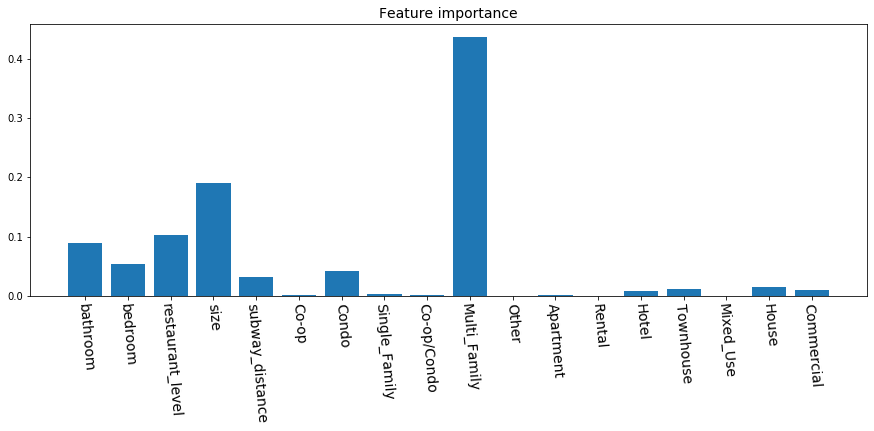

In [66]:
cols = list(df.columns)[0:-1]
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), XGBModel.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-85, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

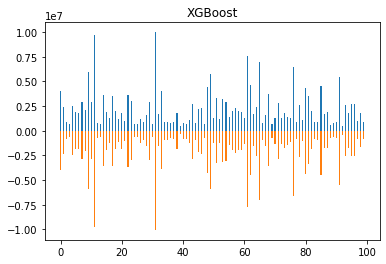

In [67]:
chart(XGBpredictions_y.reshape(-1,1),y_test, 100, 200, 'XGBoost')